# 基于能量的深度生成模型



In [2]:
## Standard libraries
import os
import json
import math
import numpy as np 
import random

## Imports for plotting
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
from mpl_toolkits.mplot3d.axes3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "/home/huilin/project/data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "/home/huilin/project/DE-model"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

/tmp/ipykernel_158920/386190955.py:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
Seed set to 42


Device: cuda:0


In [3]:
# Transformations applied on each image => make them a tensor and normalize between -1 and 1
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))
                               ])

# Loading the training dataset. We need to split it into a training and validation part
train_set = MNIST(root=DATASET_PATH, train=True, transform=transform, download=True)

# Loading the test set
test_set = MNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
# Note that for actually training a model, we will use different data loaders
# with a lower batch size.
train_loader = data.DataLoader(train_set, batch_size=128, shuffle=True,  drop_last=True,  num_workers=4, pin_memory=True)
test_loader  = data.DataLoader(test_set,  batch_size=256, shuffle=False, drop_last=False, num_workers=4)

In [4]:
class Swish(nn.Module):
    
    def forward(self, x):
        return x * torch.sigmoid(x)


class CNNModel(nn.Module):

    def __init__(self, hidden_features=32, out_dim=1, **kwargs):
        super().__init__()
        # We increase the hidden dimension over layers. Here pre-calculated for simplicity.
        c_hid1 = hidden_features//2
        c_hid2 = hidden_features
        c_hid3 = hidden_features*2
        
        # Series of convolutions and Swish activation functions
        self.cnn_layers = nn.Sequential(
                nn.Conv2d(1, c_hid1, kernel_size=5, stride=2, padding=4), # [16x16] - Larger padding to get 32x32 image
                Swish(),
                nn.Conv2d(c_hid1, c_hid2, kernel_size=3, stride=2, padding=1), #  [8x8]
                Swish(),
                nn.Conv2d(c_hid2, c_hid3, kernel_size=3, stride=2, padding=1), # [4x4]
                Swish(),
                nn.Conv2d(c_hid3, c_hid3, kernel_size=3, stride=2, padding=1), # [2x2]
                Swish(),
                nn.Flatten(),
                nn.Linear(c_hid3*4, c_hid3),
                Swish(),
                nn.Linear(c_hid3, out_dim)
        )

    def forward(self, x):
        x = self.cnn_layers(x).squeeze(dim=-1)
        return x



下面的部分中，模型的输出实际上并不代表 $E_{\theta}(\mathbf{x})$，而是代表 $-E_{\theta}(\mathbf{x})$。
这是基于能量的模型的标准实现实践，因为有些人也将能量概率密度写为 $q_{\theta}(\mathbf{x}) = \frac{\exp\left(f_{\theta}( \mathbf{x})\right)}{Z_{\theta}}$。在这种情况下，模型实际上代表 $f_{\theta}(\mathbf{x})$。在训练损失等方面， 需要注意不要调换正负号。

In [5]:
class Sampler:

    def __init__(self, model, img_shape, sample_size, max_len=8192):
        """
        Inputs:
            model - Neural network to use for modeling E_theta
            img_shape - Shape of the images to model
            sample_size - Batch size of the samples
            max_len - Maximum number of data points to keep in the buffer
        """
        super().__init__()
        self.model = model
        self.img_shape = img_shape
        self.sample_size = sample_size
        self.max_len = max_len
        self.examples = [(torch.rand((1,)+img_shape)*2-1) for _ in range(self.sample_size)]

    def sample_new_exmps(self, steps=60, step_size=10):
        """
        Function for getting a new batch of "fake" images.
        Inputs:
            steps - Number of iterations in the MCMC algorithm
            step_size - Learning rate nu in the algorithm above
        """
        # Choose 95% of the batch from the buffer, 5% generate from scratch
        n_new = np.random.binomial(self.sample_size, 0.05)
        rand_imgs = torch.rand((n_new,) + self.img_shape) * 2 - 1
        old_imgs = torch.cat(random.choices(self.examples, k=self.sample_size-n_new), dim=0)
        inp_imgs = torch.cat([rand_imgs, old_imgs], dim=0).detach().to(device)

        # Perform MCMC sampling
        inp_imgs = Sampler.generate_samples(self.model, inp_imgs, steps=steps, step_size=step_size)

        # Add new images to the buffer and remove old ones if needed
        self.examples = list(inp_imgs.to(torch.device("cpu")).chunk(self.sample_size, dim=0)) + self.examples
        self.examples = self.examples[:self.max_len]
        return inp_imgs

    @staticmethod
    def generate_samples(model, inp_imgs, steps=60, step_size=10, return_img_per_step=False):
        """
        Function for sampling images for a given model. 
        Inputs:
            model - Neural network to use for modeling E_theta
            inp_imgs - Images to start from for sampling. If you want to generate new images, enter noise between -1 and 1.
            steps - Number of iterations in the MCMC algorithm.
            step_size - Learning rate nu in the algorithm above
            return_img_per_step - If True, we return the sample at every iteration of the MCMC
        """
        # Before MCMC: set model parameters to "required_grad=False"
        # because we are only interested in the gradients of the input. 
        is_training = model.training
        model.eval()
        for p in model.parameters():
            p.requires_grad = False
        inp_imgs.requires_grad = True
        
        # Enable gradient calculation if not already the case
        had_gradients_enabled = torch.is_grad_enabled()
        torch.set_grad_enabled(True)
        
        # We use a buffer tensor in which we generate noise each loop iteration.
        # More efficient than creating a new tensor every iteration.
        noise = torch.randn(inp_imgs.shape, device=inp_imgs.device)
        
        # List for storing generations at each step (for later analysis)
        imgs_per_step = []
        
        # Loop over K (steps)
        for _ in range(steps):
            # Part 1: Add noise to the input.
            noise.normal_(0, 0.005)
            inp_imgs.data.add_(noise.data)
            inp_imgs.data.clamp_(min=-1.0, max=1.0)
            
            # Part 2: calculate gradients for the current input.
            out_imgs = -model(inp_imgs)
            out_imgs.sum().backward()
            inp_imgs.grad.data.clamp_(-0.03, 0.03) # For stabilizing and preventing too high gradients

            # Apply gradients to our current samples
            inp_imgs.data.add_(-step_size * inp_imgs.grad.data)
            inp_imgs.grad.detach_()
            inp_imgs.grad.zero_()
            inp_imgs.data.clamp_(min=-1.0, max=1.0)
            
            if return_img_per_step:
                imgs_per_step.append(inp_imgs.clone().detach())
        
        # Reactivate gradients for parameters for training
        for p in model.parameters():
            p.requires_grad = True
        model.train(is_training)
        
        # Reset gradient calculation to setting before this function
        torch.set_grad_enabled(had_gradients_enabled)

        if return_img_per_step:
            return torch.stack(imgs_per_step, dim=0)
        else:
            return inp_imgs

在下面的算法中，缓冲区的想法变得更加清晰。

In [6]:
class DeepEnergyModel(pl.LightningModule):
    
    def __init__(self, img_shape, batch_size, alpha=0.1, lr=1e-4, beta1=0.0, **CNN_args):
        super().__init__()
        self.save_hyperparameters()
        
        self.cnn = CNNModel(**CNN_args)
        self.sampler = Sampler(self.cnn, img_shape=img_shape, sample_size=batch_size)
        self.example_input_array = torch.zeros(1, *img_shape)
 
    def forward(self, x):
        z = self.cnn(x)
        return z

    def configure_optimizers(self):
        # Energy models can have issues with momentum as the loss surfaces changes with its parameters. 
        # Hence, we set it to 0 by default. 
        optimizer = optim.Adam(self.parameters(), lr=self.hparams.lr, betas=(self.hparams.beta1, 0.999))
        scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.97) # Exponential decay over epochs
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        # We add minimal noise to the original images to prevent the model from focusing on purely "clean" inputs
        real_imgs, _ = batch
        small_noise = torch.randn_like(real_imgs) * 0.005
        real_imgs.add_(small_noise).clamp_(min=-1.0, max=1.0)
        
        # Obtain samples
        fake_imgs = self.sampler.sample_new_exmps(steps=60, step_size=10)
        
        # Predict energy score for all images
        inp_imgs = torch.cat([real_imgs, fake_imgs], dim=0)
        real_out, fake_out = self.cnn(inp_imgs).chunk(2, dim=0)
        
        # Calculate losses
        reg_loss = self.hparams.alpha * (real_out ** 2 + fake_out ** 2).mean()
        cdiv_loss = fake_out.mean() - real_out.mean()
        loss = reg_loss + cdiv_loss
        
        # Logging
        self.log('loss', loss)
        self.log('loss_regularization', reg_loss)
        self.log('loss_contrastive_divergence', cdiv_loss)
        self.log('metrics_avg_real', real_out.mean())
        self.log('metrics_avg_fake', fake_out.mean())
        return loss

    def validation_step(self, batch, batch_idx):
        # For validating, we calculate the contrastive divergence between purely random images and unseen examples
        # Note that the validation/test step of energy-based models depends on what we are interested in the model
        real_imgs, _ = batch
        fake_imgs = torch.rand_like(real_imgs) * 2 - 1
        
        inp_imgs = torch.cat([real_imgs, fake_imgs], dim=0)
        real_out, fake_out = self.cnn(inp_imgs).chunk(2, dim=0)
        
        cdiv = fake_out.mean() - real_out.mean()
        self.log('val_contrastive_divergence', cdiv)
        self.log('val_fake_out', fake_out.mean())
        self.log('val_real_out', real_out.mean())

In [7]:
class GenerateCallback(pl.Callback):

    def __init__(self, batch_size=8, vis_steps=8, num_steps=256, every_n_epochs=5):
        super().__init__()
        self.batch_size = batch_size         # Number of images to generate
        self.vis_steps = vis_steps           # Number of steps within generation to visualize
        self.num_steps = num_steps           # Number of steps to take during generation
        self.every_n_epochs = every_n_epochs # Only save those images every N epochs (otherwise tensorboard gets quite large)

    def on_epoch_end(self, trainer, pl_module):
        # Skip for all other epochs
        if trainer.current_epoch % self.every_n_epochs == 0:
            # Generate images
            imgs_per_step = self.generate_imgs(pl_module)
            # Plot and add to tensorboard
            for i in range(imgs_per_step.shape[1]):
                step_size = self.num_steps // self.vis_steps
                imgs_to_plot = imgs_per_step[step_size-1::step_size,i]
                grid = torchvision.utils.make_grid(imgs_to_plot, nrow=imgs_to_plot.shape[0], normalize=True, range=(-1,1))
                trainer.logger.experiment.add_image(f"generation_{i}", grid, global_step=trainer.current_epoch)
                
    def generate_imgs(self, pl_module):
        pl_module.eval()
        start_imgs = torch.rand((self.batch_size,) + pl_module.hparams["img_shape"]).to(pl_module.device)
        start_imgs = start_imgs * 2 - 1
        torch.set_grad_enabled(True)  # Tracking gradients for sampling necessary
        imgs_per_step = Sampler.generate_samples(pl_module.cnn, start_imgs, steps=self.num_steps, step_size=10, return_img_per_step=True)
        torch.set_grad_enabled(False)
        pl_module.train()
        return imgs_per_step

第二个回调称为“SamplerCallback”，它只是将采样缓冲区中随机选取的图像子集添加到 TensorBoard。这有助于了解当前向模型显示的哪些图像是“假的”。

In [8]:
class SamplerCallback(pl.Callback):
    
    def __init__(self, num_imgs=32, every_n_epochs=5):
        super().__init__()
        self.num_imgs = num_imgs             # Number of images to plot
        self.every_n_epochs = every_n_epochs # Only save those images every N epochs (otherwise tensorboard gets quite large)
        
    def on_epoch_end(self, trainer, pl_module):
        if trainer.current_epoch % self.every_n_epochs == 0:
            exmp_imgs = torch.cat(random.choices(pl_module.sampler.examples, k=self.num_imgs), dim=0)
            grid = torchvision.utils.make_grid(exmp_imgs, nrow=4, normalize=True, range=(-1,1))
            trainer.logger.experiment.add_image("sampler", grid, global_step=trainer.current_epoch)


最后， 最后一个回调是“OutlierCallback”。此回调通过记录分配给随机噪声的（负）能量来评估模型。虽然 训练损失在迭代中几乎是恒定的，但这个分数可能显示了模型检测“异常值”的进度。

In [9]:
class OutlierCallback(pl.Callback):
    
    def __init__(self, batch_size=1024):
        super().__init__()
        self.batch_size = batch_size
    
    def on_epoch_end(self, trainer, pl_module):
        with torch.no_grad():
            pl_module.eval()
            rand_imgs = torch.rand((self.batch_size,) + pl_module.hparams["img_shape"]).to(pl_module.device)
            rand_imgs = rand_imgs * 2 - 1.0
            rand_out = pl_module.cnn(rand_imgs).mean()
            pl_module.train()
        
        trainer.logger.experiment.add_scalar("rand_out", rand_out, global_step=trainer.current_epoch)

### 运行模型

最后， 可以将所有内容添加到一起来创建最终的训练函数。该函数与 迄今为止看到的任何其他 PyTorch Lightning 训练函数非常相似。然而，有一个小小的区别， 不会在测试集上测试模型，因为 随后将通过检查其预测和执行异常值检测的能力来分析模型。

In [10]:
def train_model(**kwargs):
    # Create a PyTorch Lightning trainer with the generation callback
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, "MNIST"),
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=60,
                         gradient_clip_val=0.1,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="min", monitor='val_contrastive_divergence'),
                                    GenerateCallback(every_n_epochs=5),
                                    SamplerCallback(every_n_epochs=5),
                                    OutlierCallback(),
                                    LearningRateMonitor("epoch")
                                   ])
    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, "MNIST.ckpt")
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model, loading...")
        model = DeepEnergyModel.load_from_checkpoint(pretrained_filename)
    else:
        pl.seed_everything(42)
        model = DeepEnergyModel(**kwargs)
        trainer.fit(model, train_loader, test_loader)
        model = DeepEnergyModel.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)
    # No testing as we are more interested in other properties
    return model

加一个模型的check

In [11]:
import os
# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "/data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "/home/huilin/project/DE-model"

pretrained_filename = os.path.join(CHECKPOINT_PATH, "MNIST.ckpt")

if os.path.isfile(pretrained_filename):
    print("Found pretrained model, loading...")
else:
    print("No model found!")
        

Found pretrained model, loading...


In [12]:
model = train_model(img_shape=(1,28,28), 
                    batch_size=train_loader.batch_size,
                    lr=1e-4,
                    beta1=0.0)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Found pretrained model, loading...


Lightning automatically upgraded your loaded checkpoint from v1.0.2 to v2.2.5. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint DE-model/MNIST.ckpt`


## 分析

在最后一部分，将尝试采用经过训练的基于能量的生成模型，并分析其属性。

### TensorBoard

 首先可以看到的是训练期间生成的 TensorBoard。这可以帮助 更好地了解训练动态，并显示潜在的问题。让 加载下面的 TensorBoard：

In [13]:
# Import tensorboard
%load_ext tensorboard

In [14]:
# Opens tensorboard in notebook. Adjust the path to your CHECKPOINT_PATH!
%tensorboard --logdir /home/huilin/Deep_Energy-Based_Generative_Models/Deep_Energy-Based_Generative_Models/

<center width="100%"><img src="tensorboard_screenshot.png" width="1000px"></center>

 看到对比散度以及正则化很快收敛到 0。然而，尽管损失始终接近于零，但训练仍在继续。这是因为 的“训练”数据通过采样随着模型的变化而变化。训练的进度可以通过查看迭代中的样本以及随时间不断下降的随机图像的分数来最好地衡量。


### 图像生成 

评估生成模型的另一种方法是对一些生成的图像进行采样。生成模型需要擅长生成逼真的图像，因为这真实地表明它们已经对真实的数据分布进行了建模。因此，让 对下面模型的一些图像进行采样：


In [15]:
model.to(device)
pl.seed_everything(43)
callback = GenerateCallback(batch_size=4, vis_steps=8, num_steps=256)
imgs_per_step = callback.generate_imgs(model)
imgs_per_step = imgs_per_step.cpu()

Seed set to 43


基于能量的模型采样的特点是需要迭代MCMC算法。为了深入了解图像在迭代过程中如何变化， 还在 MCMC 中绘制了一些中间样本：

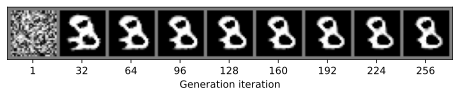

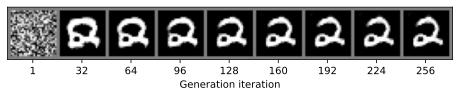

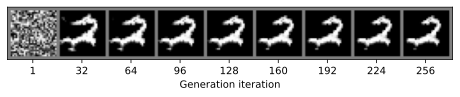

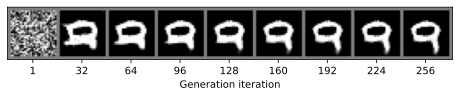

In [16]:
for i in range(imgs_per_step.shape[1]):
    step_size = callback.num_steps // callback.vis_steps
    imgs_to_plot = imgs_per_step[step_size-1::step_size,i]
    imgs_to_plot = torch.cat([imgs_per_step[0:1,i],imgs_to_plot], dim=0)
    grid = torchvision.utils.make_grid(imgs_to_plot, nrow=imgs_to_plot.shape[0], normalize=True, value_range=(-1,1), pad_value=0.5, padding=2)
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(8,8))
    plt.imshow(grid)
    plt.xlabel("Generation iteration")
    plt.xticks([(imgs_per_step.shape[-1]+2)*(0.5+j) for j in range(callback.vis_steps+1)], 
               labels=[1] + list(range(step_size,imgs_per_step.shape[0]+1,step_size)))
    plt.yticks([])
    plt.show()

 可以看到，虽然第一步是从噪声开始的，但采样算法仅经过 32 个步骤就获得了合理的形状。
 在接下来的 200 步中，形状变得更加清晰并变为真实的数字。当您在不同平台上运行代码时，具体示例可能会有所不同，因此以下描述特定于网站上显示的图。第一行显示 8， 在迭代中删除不必要的白色部分。第二个样本最多可以看到迭代之间的变换，它创建了一个数字 2。虽然 32 次迭代后的第一个样本看起来有点像数字，但实际上并非如此，该样本越来越多地转换为典型图像数字2的.

### 分布外检测 

基于能量的模型的一个非常常见且强大的应用是分布外检测（有时称为“异常”检测）。随着越来越多的深度学习模型应用于生产和应用中，这些模型的一个重要方面是了解模型不知道什么。深度学习模型通常过于自信，这意味着它们有时甚至以 100% 的概率对随机图像进行分类。显然，这不是 希望在应用程序中看到的情况。基于能量的模型可以帮助解决这个问题，因为它们经过训练可以检测不适合训练数据集分布的图像。因此，在这些应用程序中，您可以与分类器一起训练基于能量的模型，并且仅当基于能量的模型为图像分配高于 $\delta$ 的（非标准化）概率时才输出预测。实际上，您可以将分类器和基于能量的目标组合在一个模型中，如本[论文](https://arxiv.org/abs/1912)中所提出的。

在这部分分析中， 想要测试基于能量的模型的分布外能力。请记住，模型的输出较低表示概率较低。因此，如果向模型输入随机噪声， 希望看到低分：

In [17]:
with torch.no_grad():
    rand_imgs = torch.rand((128,) + model.hparams.img_shape).to(model.device)
    rand_imgs = rand_imgs * 2 - 1.0
    rand_out = model.cnn(rand_imgs).mean()
    print(f"Average score for random images: {rand_out.item():4.2f}")

Average score for random images: -17.88


正如所希望的，该模型为这些噪声图像分配了非常低的概率。作为另一个参考，让看一下对训练集中的一批图像的预测：

In [18]:
with torch.no_grad():
    train_imgs,_ = next(iter(train_loader))
    train_imgs = train_imgs.to(model.device)
    train_out = model.cnn(train_imgs).mean()
    print(f"Average score for training images: {train_out.item():4.2f}")

Average score for training images: -0.01


由于训练中添加了正则化目标，分数接近 0。很明显，该模型可以区分噪声和真实数字。然而，如果 稍微改变一下训练图像，看看哪些图像得分非常低，会发生什么？

In [19]:
@torch.no_grad()
def compare_images(img1, img2):
    imgs = torch.stack([img1, img2], dim=0).to(model.device)
    score1, score2 = model.cnn(imgs).cpu().chunk(2, dim=0)
    grid = torchvision.utils.make_grid([img1.cpu(), img2.cpu()], nrow=2, normalize=True, value_range=(-1,1), pad_value=0.5, padding=2)
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(4,4))
    plt.imshow(grid)
    plt.xticks([(img1.shape[2]+2)*(0.5+j) for j in range(2)],
               labels=["Original image", "Transformed image"])
    plt.yticks([])
    plt.show()
    print(f"Score original image: {score1.item():4.2f}")
    print(f"Score transformed image: {score2.item():4.2f}")

 为此使用随机测试图像。大家可以随意更改它以亲自尝试该模型。

In [20]:
test_imgs, _ = next(iter(test_loader))
exmp_img = test_imgs[0].to(model.device)

第一个变换是向图像添加一些随机噪声：

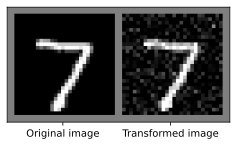

Score original image: 0.03
Score transformed image: -0.07


In [21]:
img_noisy = exmp_img + torch.randn_like(exmp_img) * 0.3
img_noisy.clamp_(min=-1.0, max=1.0)
compare_images(exmp_img, img_noisy)

可以看到分数大幅下降。因此，该模型可以检测图像上的随机高斯噪声。这也是预期的，因为最初，“假”样本是纯噪声图像。

接下来， 翻转图像并检查这对分数的影响：

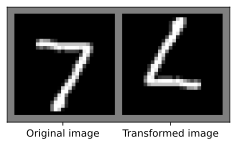

Score original image: 0.03
Score transformed image: -0.00


In [22]:
img_flipped = exmp_img.flip(dims=(1,2))
compare_images(exmp_img, img_flipped)

如果数字只能用这种方式读出，例如7，那么 可以看到分数下降了。然而，分数仅略有下降。这可能是因为 的模型尺寸较小。请记住，生成建模是一项比分类困难得多的任务，因为 不仅需要区分类别，还需要学习数字的**所有**细节/特征。通过更深入的模型，最终可以更好地捕获这一点（但代价是训练的稳定性更大）。

最后， 检查一下如果显着减小数字的大小会发生什么：

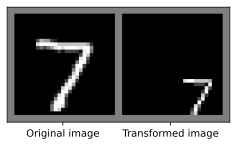

Score original image: 0.03
Score transformed image: -0.02


: 

In [23]:
img_tiny = torch.zeros_like(exmp_img)-1
img_tiny[:,exmp_img.shape[1]//2:,exmp_img.shape[2]//2:] = exmp_img[:,::2,::2]
compare_images(exmp_img, img_tiny)


尽管 MNIST 数据集中的数字通常要大得多，但分数再次下降，但幅度不大。

总的来说， 可以得出结论， 的模型适合检测高斯噪声和对现有数字的较小变换。尽管如此，为了获得非常好的分布外模型， 需要训练更深的模型并进行更多的迭代。

### 不稳定性 

最后， 应该讨论基于能量的模型可能存在的不稳定性，特别是 在本笔记本中实现的图像生成示例。在这款笔记本的超参数搜索过程中，出现了多个模型出现分歧。基于能量的模型的发散意味着模型将高概率分配给训练集的示例，这是一件好事。然而，与此同时，采样算法失败并且仅生成获得最小概率分数的噪声图像。发生这种情况是因为模型创建了许多局部最大值，生成的噪声图像落入其中。 计算梯度以高概率到达数据点的能量表面已经“发散”，对 的 MCMC 采样没有用处。

除了寻找最佳超参数之外，基于能量的模型中的一个常见技巧是重新加载稳定的检查点。如果 检测到模型正在发散， 就会停止训练，从一个时期之前尚未发散的模型加载模型。之后， 继续训练，并希望使用不同的种子模型不会再次发散。尽管如此，这应该被视为稳定模型的“最后希望”，而仔细的超参数调整是更好的方法。敏感超参数包括采样器中的“step_size”、“steps”和噪声标准差，以及 CNN 模型中的学习率和特征维度。

## 结论

在本教程讨论了用于生成建模的基于能量的模型。该概念依赖于这样的想法：通过对整个数据集进行归一化，任何严格的正函数都可以转化为概率分布。由于这对于图像等高维数据的计算是不合理的，因此 使用对比散度和通过 MCMC 采样来训练模型。虽然这个想法允许 将任何神经网络转变为基于能量的模型，但 已经看到需要多种训练技巧来稳定训练。此外，这些模型的训练时间相对较长，因为在每次训练迭代期间，即使使用采样缓冲区， 也需要采样新的“假”图像。在接下来的讲座和作业中， 将看到不同的生成模型（例如VAE、GAN、NF），它们使 能够更稳定地进行生成建模，但代价是更多参数。